# Checking the TCGA data

We create datasets using the TCGA data



## Setup imports

In [1]:
import os
import shutil

import matplotlib.pyplot as plt
import numpy as np

from monai.data import partition_dataset, CacheDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.transforms import (
    AddChanneld,
    Activations,
    AsChannelFirstd,
    AsDiscrete,
    CenterSpatialCropd,
    Compose,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    ToTensord,
)
from monai.utils import set_determinism

import torch
from torch.utils.data import random_split, ConcatDataset

from tqdm import tqdm

############################################
# Local imports

SOURCE_CODE_PATH = '/homes/yc7620/Documents/medical-vision-textural-bias/source_code/'
import sys
sys.path.append(SOURCE_CODE_PATH)

from filters_and_operators import RandFourierDiskMaskd, ConvertToMultiChannelBasedOnBratsClassesd, SelectChanneld, WholeTumorTCGA
from utils import show_slice_and_fourier, model_evaluation, ReCompose
#############################################

# set determinism for reproducibility
set_determinism(seed=0)


root_dir = '/vol/bitbucket/yc7620/90_data/53_TCGA_data/'
print('root_dir', root_dir)
print_config()

device = torch.device("cuda:0")

root_dir /vol/bitbucket/yc7620/90_data/53_TCGA_data/
MONAI version: 0.5.dev2113
Numpy version: 1.19.2
Pytorch version: 1.8.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: b3cc668c924b2a7e6b822416f4d920a098c27704

Optional dependencies:
Pytorch Ignite version: 0.4.4
Nibabel version: 3.2.1
scikit-image version: 0.17.2
Pillow version: 8.1.2
Tensorboard version: 2.5.0
gdown version: 3.12.2
TorchVision version: 0.9.0
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.50.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



# Create datasets

In [2]:
import json

with open(os.path.join(root_dir, 'test_sequence_by_modality.json'), 'r') as f:
    test_seqs_4mods = json.load(f)
with open(os.path.join(root_dir, 'train_sequence_by_modality.json'), 'r') as f:
    data_seqs_4mods = json.load(f)

# split off training and validation     
train_seq_flair, val_seq_flair = partition_dataset(data_seqs_4mods["FLAIR"], [0.9, 0.1], shuffle=True, seed=0)
train_seq_t1, val_seq_t1 = partition_dataset(data_seqs_4mods["T1"], [0.9, 0.1], shuffle=True, seed=0)
train_seq_t1gd, val_seq_t1gd = partition_dataset(data_seqs_4mods["T1Gd"], [0.9, 0.1], shuffle=True, seed=0)
train_seq_t2, val_seq_t2 = partition_dataset(data_seqs_4mods["T2"], [0.9, 0.1], shuffle=True, seed=0)

Example of packaged data:

In [3]:
train_seq_flair[0]

{'image': '/vol/bitbucket/yc7620/90_data/53_TCGA_data/training/TCGA-DU-7010/TCGA-DU-7010_1986.03.07_flair.nii.gz',
 'label': '/vol/bitbucket/yc7620/90_data/53_TCGA_data/training/TCGA-DU-7010/TCGA-DU-7010_1986.03.07_GlistrBoost_ManuallyCorrected.nii.gz'}

## Baseline pipeline

In [25]:
class WholeTumorTCGA(MapTransform):
    """
    Convert TCGA segmentation map to whole tumor segmentation.
    """
    def __init__(self, keys, allow_missing_keys=False):
        MapTransform.__init__(self, keys, allow_missing_keys)
                              
    def __call__(self, data):
        d = dict(data)
        for key in self.key_iterator(d):
            d[key] = (d[key] != 0)[None,:].astype(np.float32) 
        return d

In [70]:
train_transform = ReCompose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys="image"),
        WholeTumorTCGA(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest")
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        RandSpatialCropd(
            keys=["image", "label"], roi_size=[128, 128, 64], random_size=False
        ),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd("image", factors=0.1, prob=0.5),
        RandShiftIntensityd("image", offsets=0.1, prob=0.5),
        ToTensord(keys=["image", "label"]),
    ]
)

val_transform = ReCompose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys="image"),
        WholeTumorTCGA(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CenterSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 64]),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
    ]
)

# split off training and validation     
train_seq_flair, val_seq_flair = partition_dataset(data_seqs_4mods["FLAIR"], [0.9, 0.1], shuffle=True, seed=0)
train_seq_t1, val_seq_t1 = partition_dataset(data_seqs_4mods["T1"], [0.9, 0.1], shuffle=True, seed=0)
train_seq_t1gd, val_seq_t1gd = partition_dataset(data_seqs_4mods["T1Gd"], [0.9, 0.1], shuffle=True, seed=0)
train_seq_t2, val_seq_t2 = partition_dataset(data_seqs_4mods["T2"], [0.9, 0.1], shuffle=True, seed=0)

# create datasets
train_ds_flair = CacheDataset(train_seq_flair, train_transform, cache_num=2)
train_ds_t1 = CacheDataset(train_seq_t1, train_transform, cache_num=2)
train_ds_t1gd = CacheDataset(train_seq_t1gd, train_transform, cache_num=2)
train_ds_t2 = CacheDataset(train_seq_t2, train_transform, cache_num=2)

val_ds_flair = CacheDataset(val_seq_flair, val_transform, cache_num=2)
val_ds_t1 = CacheDataset(val_seq_t1, val_transform, cache_num=2)
val_ds_t1gd = CacheDataset(val_seq_t1gd, val_transform, cache_num=2)
val_ds_t2 = CacheDataset(val_seq_t2, val_transform, cache_num=2)

val_ds = ConcatDataset([val_ds_flair, val_ds_t1, val_ds_t1gd, val_ds_t2])
train_ds = ConcatDataset([train_ds_flair, train_ds_t1, train_ds_t1gd, train_ds_t2])

# dataloaders
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=2, shuffle=False, num_workers=4)

Loading dataset: 100%|██████████| 2/2 [00:00<00:00,  3.15it/s]


In [75]:
# testing dataset (holdout hospital)

test_ds_flair = CacheDataset(test_seqs_4mods["FLAIR"], val_transform, cache_num=2)
test_ds_t1 = CacheDataset(test_seqs_4mods["T1"], val_transform, cache_num=2)
test_ds_t1gd = CacheDataset(test_seqs_4mods["T1Gd"], val_transform, cache_num=2)
test_ds_t2 = CacheDataset(test_seqs_4mods["T2"], val_transform, cache_num=2)

test_ds = ConcatDataset([test_ds_flair, test_ds_t1, test_ds_t1gd, test_ds_t2])

Loading dataset: 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]


In [76]:
print(f"Number of training instances = {len(train_ds)}.")
print(f"Number of validation instances = {len(val_ds)}.")
print(f"Number of testing instances (holdout hospital) = {len(test_ds)}." )

Number of training instances = 536.
Number of validation instances = 60.
Number of testing instances (holdout hospital) = 72.


## Check data shape and visualize

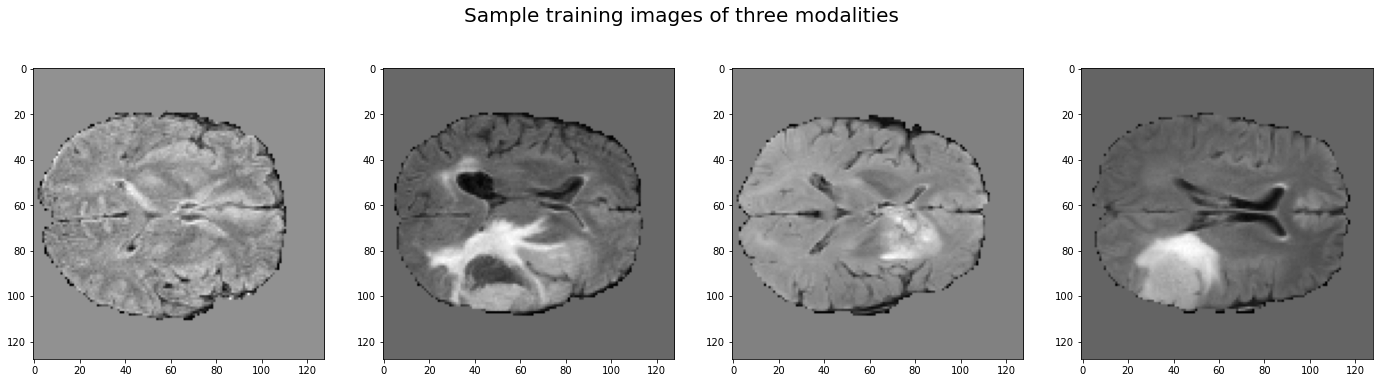

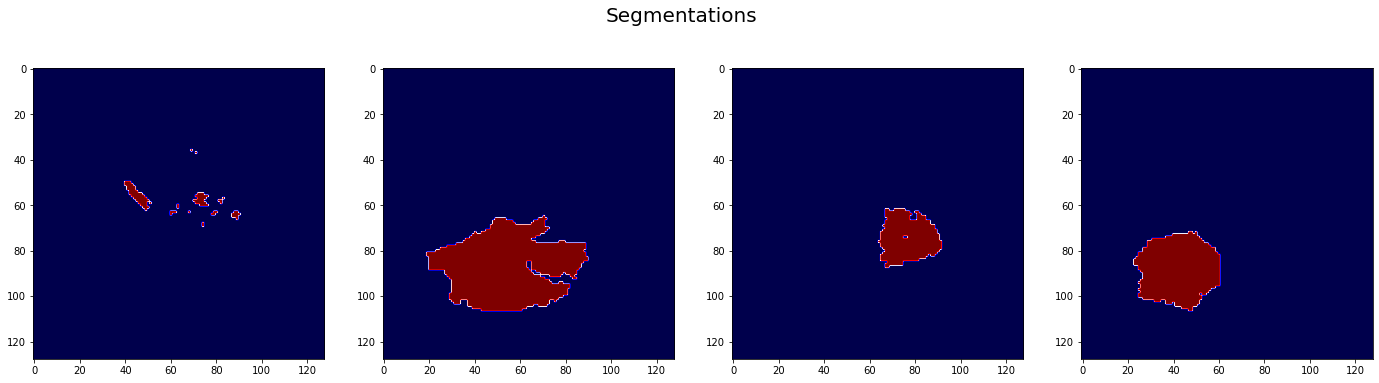

In [73]:
plt.figure(figsize=(24,6))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.suptitle("Sample training images of three modalities", size = 20)
    plt.imshow(val_ds[i+7]['image'][0, :, :, 32].detach().cpu(), cmap="gray")
plt.show()
plt.figure(figsize=(24,6))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.suptitle("Segmentations", size = 20)
    plt.imshow(val_ds[i+7]['label'][0, :, :, 32].detach().cpu(), cmap="seismic")
plt.show()

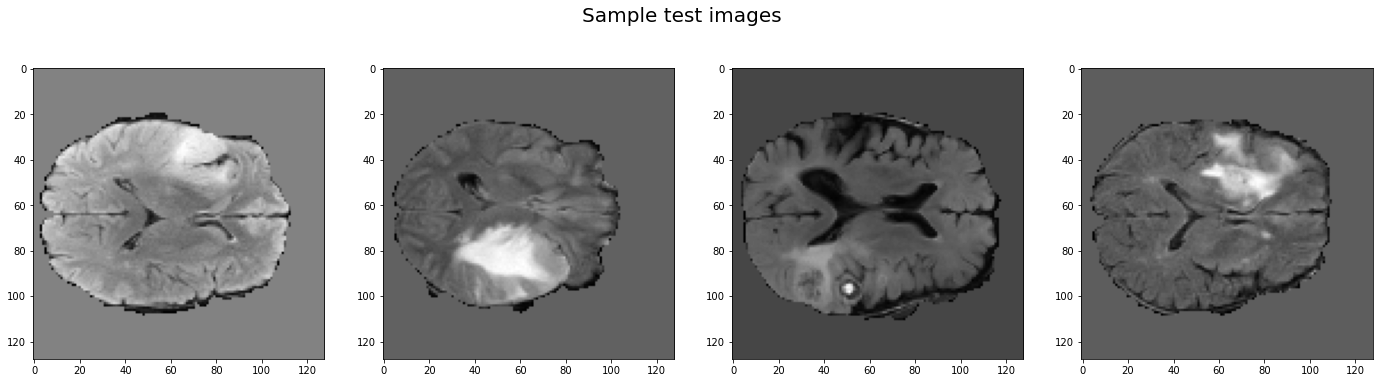

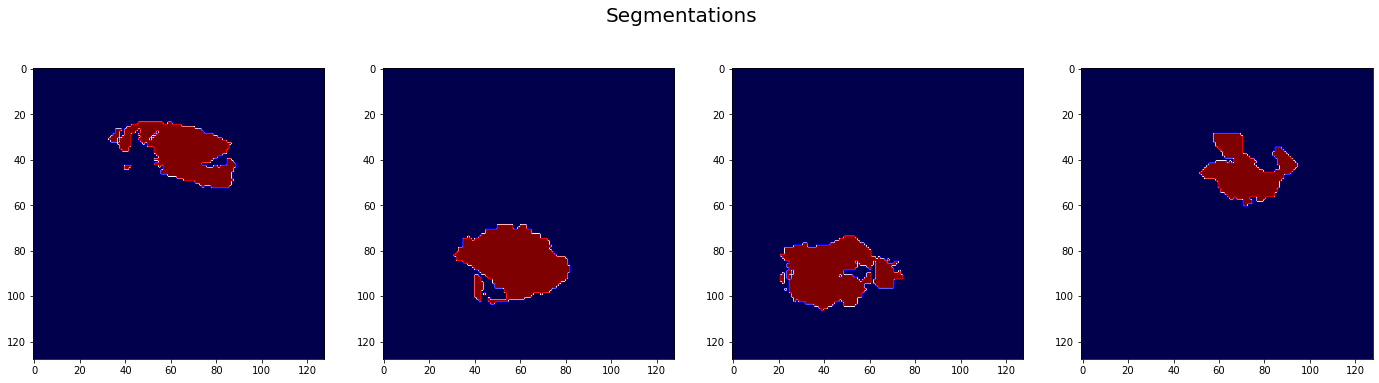

In [83]:
plt.figure(figsize=(24,6))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.suptitle("Sample test images", size = 20)
    plt.imshow(test_ds[i]['image'][0, :, :, 32], cmap="gray")
plt.show()
plt.figure(figsize=(24,6))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.suptitle("Segmentations", size = 20)
    plt.imshow(test_ds[i]['label'][0, :, :, 32], cmap="seismic")
plt.show()